# MBTI Personality Prediction

In this challenge I have to train a model / models capable of predicting a person's MBTI personality type using only what they post online. Using Logistic regression and support vector classifier on the dataset of MBTI from Kaggle I made predictions on each of the four MBTI variables to determine a person's personality based on their online posts.





<img src="https://img1.wsimg.com/isteam/ip/1d2cb0e7-8a35-4d84-b42d-e51f7e92c477/25eba0b3-9341-4232-b14c-aebdf9622c32.png/:/cr=t:0%25,l:0%25,w:100%25,h:100%25/rs=h:650,cg:true" alt="Drawing" style="width: 500px;"/>

# Content Overview:

- MBTI overview
- Exploratory Analysis
- Text Processing
 - Cleaning
 - Vectorization
<br> 
- Modelling
 - Cross Validation
 - Model performance measures
 - Logistic Regression
 - Support Vector Classifier
<br> 
- Conclusion
 - Results

## The Myers–Briggs Type Indicator 

The Myers–Briggs Type Indicator (MBTI) is an introspective self-report questionnaire with the purpose of indicating differing psychological preferences in how people perceive the world around them and make decisions. 

The Myers Briggs model is established on four preferences namely:

- Types of social interaction
- Preference for gathering data
- Preference for decision making
- Style of decision making

The prescribed Myers Briggs type of indicatorpreferences include eight leadership styles:

- E or I (Extraversion or Introversion)
- S or N (Sensing or iNtuition)
- T or F (Thinking or Feeling)
- J or P (Judgment or Perception)

The 16 personalities of MBTI are defined as follows:
<br>
ISTJ - The Inspector  || ISTP - The Crafter ||  ISFJ - The Protector || ISFP - The Artist
<br>
INFJ - The Advocate   || INFP - The Mediator || INTJ - The Architect  || INTP - The Thinker
<br>
ESTP - The Persuader ||  ESTJ - The Director || ESFP - The Performer ||  ESFJ - The Caregiver
<br>
ENFP - The Champion ||  ENFJ - The Giver  ||   ENTP - The Debater  ||  ENTJ - The Commander

Reference Link - https://www.tutorialspoint.com/individual_and_group_behavior/myers_briggs_types_indicator.htm

### Import libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from nltk.corpus import stopwords
# sklearn Library
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import f1_score # better metric 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.svm import SVC
# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
# ignoring warnings for goof appearance of the notebook. 
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
#Use pandas to read the csv files
df_train = pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')

# Exploratory Analysis

For exploratory analysis I display the unclean data. I later count the number of posts for each of the 16 personalities and observe the distribution of the bar graph. The next step is to display a wordcloud for each personality. A wordcloud is a image of the most appearing words of the post of that specific personality. 

In [ ]:
#Explore a few rows in the train data
df_train.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [ ]:
#Total number of posts for each personality type
personality_types = df_train['type'].value_counts()

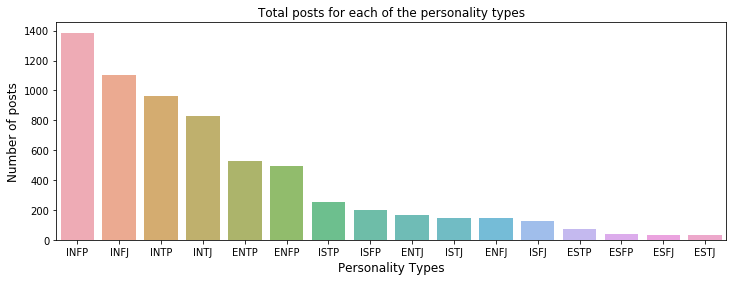

In [ ]:
#Check the ditribution of MBTI personality types
plt.figure(figsize=(12,4))
sns.barplot(personality_types.index, personality_types.values, alpha=0.8)
plt.ylabel('Number of posts', fontsize=12)
plt.xlabel('Personality Types', fontsize=12)
plt.title('Total posts for each of the personality types')
plt.show()

We can see that the distribution of our data is unbalanced throughout the different classes. This might create a problem when we fit the data into a model. The balancing of class weights will be done in the modelling section.

We now show the most frequent word among the given personality types. 

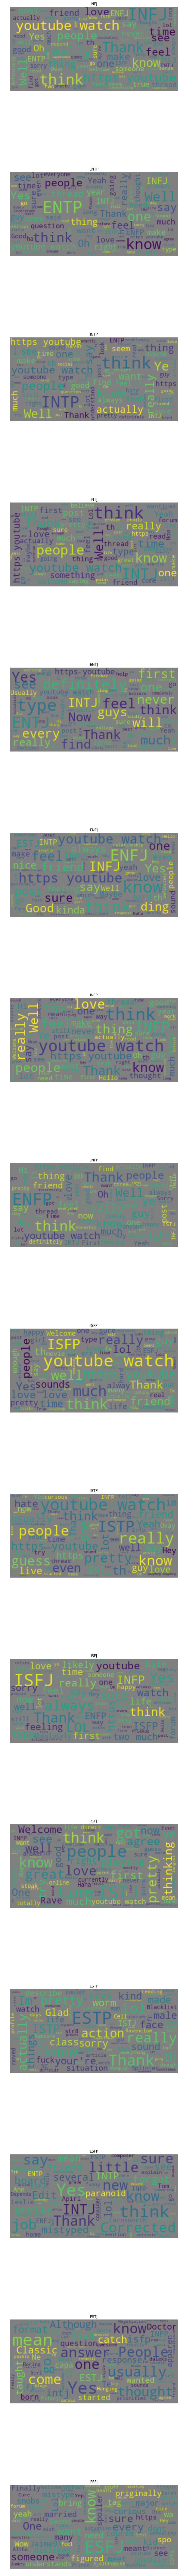

In [ ]:
fig, ax = plt.subplots(len(df_train['type'].unique()), sharex=True, figsize=(10,10*len(df_train['type'].unique())))
count = 0
for i in df_train['type'].unique():
    df_4 = df_train[df_train['type'] == i]
    wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="gray").generate(df_4['posts'].to_string())
    ax[count].imshow(wordcloud, interpolation='bilinear')
    ax[count].set_title(i)
    ax[count].axis("off")
    count+=1

In [ ]:
#concatenate the train and the test dataset
all_data=pd.concat([df_train[['posts']],df_test[['posts']]])

In [ ]:
#checking the data for missing values
all_data.isnull().any()

posts    False
dtype: bool

There appears to be no missing values in our post feature. 

In [ ]:
#check the size of the dataset
all_data.shape

(8675, 1)

# Text Processing

The text processing is broken up into two operations, cleaning the post data and vectorizing the cleaned post data by making use of the Tf-idf Vectorizer.

The cleaning process is defined as follows:
- Removing the url links 
- Striping punctuations
- Convert text to lowercase
- Removing numbers from the dataframe

## Cleaning

In [ ]:
def clean_data(df, column):
    '''
    This function applies methodologies that clean the data.

    parameters:
    df (obj) : dataframe of uncleaned posts
    column (obj) : string value, column name of dataframe df

    return:
    df (obj) : dataframe of cleaned data post column

    '''
    # remove url links
    df[column] = df[column].apply(lambda x: re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|", " ") + " "))
    # strip punctuation
    df[column] = df[column].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    # convert text to lowercase
    df[column] = df[column].str.lower()
    # remove numbers from the dataframe
    df[column] = df[column].apply(lambda x: re.sub('[0-9]+', '', x))
    # returning the clean dataframe
    return df

In [ ]:
# Making use of the clean_data function
all_data=clean_data(all_data, 'posts')

In [ ]:
#Explore the data after cleaning
all_data.head()

,posts
0,enfp and intj moments sportscenter not t...
1,im finding the lack of me in these posts very ...
2,good one _____ of course to which i say i...
3,dear intp i enjoyed our conversation the oth...
4,youre fired thats another silly misconceptio...


We have completed the text processing and now can move onto the next step which is the vectorization of the post data.

In [ ]:
# saving the clean data to a csv
all_data.to_csv('all_data.csv', index=False)

In [ ]:
# reading the csv of the clean dataframe
all_data = pd.read_csv('all_data.csv')

## Vectorization

The Tf-idf Vectorizer short for term frequency–inverse document frequency,transform text to feature vectors that can be used as input to estimators. It removes meaningless words and assigns more weight to words which have importance on the post data. 

The vectorizer has removed stop words. A stop word is a commonly used word such as “the”, “a”, “an”, “in”.

Application of stop words on sample text:
<br>
<img src="https://www.geeksforgeeks.org/wp-content/uploads/Stop-word-removal-using-NLTK.png" alt="Drawing" style="width: 500px;"/>
<br> Image reference - https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

In [ ]:
# Create the transform 
vectorizer = TfidfVectorizer(ngram_range=(1,1), analyzer='word' ,stop_words='english')
all_data = vectorizer.fit_transform(all_data['posts'])

Splitting the all_data frame into a test and train set. We also have our target variable y which is the type column from df_train.

In [ ]:
# Demerging the train and test dataframe from the all_data dataframe. 
len_slice = df_train.shape[0] 
# Slice train data frame from all_data dataframe
train = all_data[:len_slice]
# Slice test data frame from all_data dataframe
test = all_data[len_slice:]
# Target variable
y = df_train['type'] 

Each of the four categories are encoded as follows: 
- Mind: I = 0, E = 1 
- Energy: S = 0, N = 1 
- Nature: F = 0, T = 1 
- Tactics: P = 0, J = 1

Where they are defined as:
- Mind: Introverted (I) or Extraverted (E) 
- Energy: Sensing (S) or Intuitive (N) 
- Nature: Feeling (F) or Thinking (T) 
- Tactics: Perceiving (P) or Judging (J) 

In [ ]:
# Applying the encoding to the target variable y
mind = y.apply(lambda x: 0 if x[0] == 'I' else 1)
energy = y.apply(lambda x: 0 if x[1] == 'S' else 1)
nature = y.apply(lambda x: 0 if x[2] == 'F' else 1)
tactics = y.apply(lambda x: 0 if x[3] == 'P' else 1)

# Modelling

For the modelling I applied logistic regression and support vector classfier on the post data. But before I fit or make predictions on the model I apply a cross vaidation strategy to get an insight on the model performance. The most reliable metric that I used is the f1-score which is a geometric average between precision and recall. Afterwards I fit and make predictions on the data using those two models.

### Logistic Regression:

Logistic regression is a classification model and is the appropriate regression analysis to implement when the target variable is binary. It is a statistical model that in its basic form uses a logistic function to model a binary target variable. I applied logistic regression due to it being a simpler classification algorithm.

Reference Link -  https://towardsdatascience.com/support-vector-machine-vs-logistic-regression-94cc2975433f

The sigmoid function is displayed graphically as follows:
<br>
<img src="https://github.com/Samantha-movius/hello-world/blob/master/logistic_reg.png?raw=true" alt="Drawing" style="width: 500px;"/>
<br>
Image reference -  https://github.com/Samantha-movius/hello-world/blob/master/logistic_reg.png?raw=true

In [ ]:
#Balanced weighted Logistic Regression
classifier = LogisticRegression(random_state=0, class_weight='balanced') 

### Defining a cross validation strategy

Cross validation (CV) is technique used to test the effectiveness of a machine learning models. It is also a resampling procedure used to evaluate a model if we have a limited data. K-folds ensures that every observation from the original dataset has the chance of appearing in the training and test set. 

In [ ]:
# Defining the k-fold
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
score = {'acc': 'accuracy', 'f1': 'f1_micro'}

### Model performance measures:

Accuracy is the count of predictions where your predicted value equals the actual value.

Accuracy is defined as follows:
<br>
$accuracy = \frac{true positive + true negative}{true positive + true negative + false positive + false negative}$

The $f_1$ score is the geometric average between the precision and recall.
<br>
The $f_1$ score is calculated as follows: $ f_1 = 2*\frac{precision*recall}{precision+recall}$

Where precision is how many selected items are relevant and recall is how many relevant items are selected.

They are both defined by the follow equations:
<br>
$precision = \frac{true positives}{true positives + false negatives}$   $\hspace{1cm}$   $recall = \frac{true positives}{true positives + false positives}$

In [ ]:
# Applying cross validation where train is the feature and mind is the target variable
val_results = cross_validate(classifier,train, mind, scoring=score,
                        cv=kfolds, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


In [ ]:
print('Logistic Regression performance for mind:')
for values in val_results:
        print(values + ' : ', val_results[values].mean())

Logistic Regression performance for mind:
fit_time :  2.6964763164520265
score_time :  0.054949951171875
test_acc :  0.8535190830674703
train_acc :  0.9442438409179026
test_f1 :  0.8535190830674703
train_f1 :  0.9442438409179026


In [ ]:
# Applying cross validation where train is the feature and energy is the target variable
val_results = cross_validate(classifier,train, energy, scoring=score,cv=kfolds, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


In [ ]:
print('Logistic Regression performance for energy:')
for values in val_results:
    print(values + ' : ', val_results[values].mean())

Logistic Regression performance for energy:
fit_time :  1.9814906597137452
score_time :  0.010378026962280273
test_acc :  0.8982483978048681
train_acc :  0.9660699405274279
test_f1 :  0.8982483978048681
train_f1 :  0.9660699405274279


In [ ]:
# applying cross validation where train is the feature and nature is the target variable
val_results = cross_validate(classifier,train, nature, scoring=score,cv=kfolds, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished


In [ ]:
print('Logistic Regression performance for nature:')
for values in val_results:
    print(values + ' : ', val_results[values].mean())

Logistic Regression performance for nature:
fit_time :  1.9787581443786622
score_time :  0.026336193084716797
test_acc :  0.8530492733073378
train_acc :  0.9306408262446542
test_f1 :  0.8530492733073378
train_f1 :  0.9306408262446542


In [ ]:
# applying cross validation where train is the feature and nature is the tactics variable
val_results = cross_validate(classifier,train, tactics, scoring=score,cv=kfolds, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished


In [ ]:
print('Logistic Regression performance for tactics:')
for values in val_results:
    print(values + ' : ', val_results[values].mean())

Logistic Regression performance for tactics:
fit_time :  1.7703283786773683
score_time :  0.011768674850463868
test_acc :  0.8141704323463269
train_acc :  0.9300259747343647
test_f1 :  0.8141704323463269
train_f1 :  0.9300259747343647


### Support Vector Classifier:

Support vector machine (SVM) fits a linear decision boundary. However, using a procedure called kernel trick it is possible for an SVM to fit a non-linear decision boundary. The objective of the support vector machine algorithm is to find the hyperplane that has the maximum margin in an $N$-dimensional space ($N$ being the number of features) that distinctly classifies the data points. Support vectors are data points that are closer to the hyperplane and influence the position and orientation of the hyperplane.



Reference Link -  https://towardsdatascience.com/support-vector-machine-vs-logistic-regression-94cc2975433f

The Support Vector Classifer is displayed graphically as follows:
<br>
<img src="https://cdn-images-1.medium.com/max/1000/1*nUpw5agP-Vefm4Uinteq-A.png" alt="Drawing" style="width: 500px;"/>
<br>
Image reference - https://cdn-images-1.medium.com/max/1000/1*nUpw5agP-Vefm4Uinteq-A.png 

I applied another model to compare with the cross validation results of the logistic regression. SVM is a more advanced model compared to logistic regression.

In [ ]:
# Balanced weighted SVC
svm_classifier = SVC(kernel='linear', random_state=0, class_weight='balanced')

### Defining a cross validation strategy

Applied cross validation strategy to the support vector classifier. 

In [ ]:
# Applying cross validation where train is the feature and mind is the target variable
val_results2 = cross_validate(svm_classifier,train, mind, scoring=score,
                        cv=kfolds, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.2min finished


In [ ]:
print('SVM performance for mind:')
for values in val_results2:
        print(values + ' : ', val_results2[values].mean())

SVM performance for mind:
fit_time :  98.88589110374451
score_time :  47.22836875915527
test_acc :  0.8482911497105045
train_acc :  0.9764831892958608
test_f1 :  0.8482911497105045
train_f1 :  0.9764831892958608


In [ ]:
# Applying cross validation where train is the feature and energy is the target variable
val_results2 = cross_validate(svm_classifier,train, energy, scoring=score,cv=kfolds, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
print('SVM performance for energy:')
for values in val_results2:
        print(values + ' : ', val_results2[values].mean())

In [ ]:
# Applying cross validation where train is the feature and tactics is the target variable
val_results2 = cross_validate(svm_classifier,train, tactics, scoring=score,cv=kfolds, n_jobs=-1, verbose=1)

In [ ]:
print('SVM performance for tactics:')
for values in val_results2:
        print(values + ' : ', val_results2[values].mean())

In [ ]:
# Applying cross validation where train is the feature and nature is the target variable
val_results2 = cross_validate(svm_classifier,train, nature, scoring=score,cv=kfolds, n_jobs=-1, verbose=1)

In [ ]:
print('SVM performance for nature:')
for values in val_results2:
        print(values + ' : ', val_results2[values].mean())

According to the test_f1 and train_f1 in the cross validation strategy for the two models used. Both models have very similiar results. But the support vector classifier performs slightly better than the logistic regression. We will now proceed to fit the data on both the models. 


Predicting probabilities on both models due to the fact that the model performance measure is the log-loss measure. 

More on the log-loss measure on the Results section. 




### Applying Logistic Regression to the data

In [ ]:
def Logistic_Regression(train_df, test_df, cate_df):
    '''
    This function fits the train dataframe and the test dataframe and makes probability predictions on the categorical dataframe.

    parameters:
    train_df (obj) : dataframe of train data
    test_df (obj) :  dataframe of test data
    cate_df (obj) : dataframe of encoded vLUES

    return:
    predictions (obj) : dataframe of predicted values

    '''
    # Instantiating the object
    classifier = LogisticRegression(random_state=0, class_weight='balanced')
    # Fitting the model
    classifier.fit(train_df, cate_df)
    # Predictions on the test dataframe
    prediction = pd.DataFrame(classifier.predict(test_df))
    # Returning the result
    return prediction


In [ ]:
# Applying the Logistic_Regression function on the mind category
M_prediction = Logistic_Regression(train, test, mind)

In [ ]:
# Applying the Logistic_Regression function on the energy category
E_prediction = Logistic_Regression(train, test, energy)

In [ ]:
# Applying the Logistic_Regression function on the nature category
N_prediction = Logistic_Regression(train, test, nature)

In [ ]:
# Applying the Logistic_Regression function on the tactics category
T_prediction = Logistic_Regression(train, test, tactics)

In [ ]:
# Concatenating our predictions into one dataframe
sub = pd.concat([M_prediction,E_prediction,N_prediction,T_prediction], axis=1)

In [ ]:
# Renaming the columns of the sub dataframe
sub.reset_index(inplace=True)
sub['index'] = sub['index'] +1
sub.columns = ['id', 'mind', 'energy', 'nature', 'tactics']

In [ ]:
# Submitting the results to a scv
sub.to_csv('LogisticRegression.csv', index=False)

### Applying SVM to the data

In [ ]:
def Support_Vector_Classifier(train_df, test_df, cate_df):
    '''
    This function fits the train dataframe and the test dataframe and makes probability predictions on the categorical dataframe.

    parameters:
    train_df (obj) : dataframe of train data
    test_df (obj) :  dataframe of test data
    cate_df (obj) : dataframe of encoded vLUES

    return:
    predictions (obj) : dataframe of predicted values

    '''
    # instantiating the object
    svm_classifier = SVC(kernel='linear', random_state=0, class_weight='balanced', probability=True)
    # fitting the model
    svm_classifier.fit(train_df, cate_df)
    # predictions on the test dataframe
    prediction = pd.DataFrame(svm_classifier.predict_proba(test_df))[1]
    # returning the result
    return prediction


In [ ]:
# Applying the Logistic_Regression function on the mind category
M_prediction2 = Support_Vector_Classifier(train, test, mind)

In [ ]:
# Applying the Logistic_Regression function on the energy category
E_prediction2 = Support_Vector_Classifier(train, test, energy)

In [ ]:
# Applying the Logistic_Regression function on the nature category
N_prediction2 = Support_Vector_Classifier(train, test, nature)

In [ ]:
# Applying the Logistic_Regression function on the tactics category
T_prediction2 = Support_Vector_Classifier(train, test, tactics)

In [ ]:
# Concatenating our predictions into one dataframe
sub2 = pd.concat([M_prediction2,E_prediction2,N_prediction2,T_prediction2], axis=1)

In [ ]:
# Renaming the columns of the sub2 dataframe
sub2.reset_index(inplace=True)
sub2['index'] = sub2['index'] +1 
sub2.columns = ['id', 'mind', 'energy', 'nature', 'tactics']

In [ ]:
# Submitting the results to a scv
sub2.to_csv('SVM.csv', index=False)

# Conclusion

The performance of the model by makes use of log-loss. Log Loss is the most important classification metric based on probabilities, a lower log-loss value means better predictions. Log Loss takes into account the uncertainty of your prediction based on how much it varies from the actual label. This gives a more nuanced view into the performance of the model.

Reference Link -  http://wiki.fast.ai/index.php/Log_Loss

# Results

Logistic Regression Score : 5.05820

Support Vector Classifier Score : 5.10600

These results display that the logistic regression performed better than the support vector classifier in the text processed mbti dataset. This could be due to the fact that logistic regression minimizes the logistic loss metric while support vector classifier minimizes the hinge loss metric. You can typically expect the support vector classifier to perform marginally better than logistic regression, but in this case logistic regression did slighly better. 

These results are as good as I can get due to the constraints placed. The results could be improved by making use of more data cleaning procedures such as getting the website titles instead of just removing them from the post data. The models I used for classification were able to correctly predict personalities using the The Myers–Briggs Type Indicator (MBTI). I made use of logistic regression due to that its a simpler model. I then made use of a more advance model known as support vector classifier to compare the cross validation results of the logistic regression model. These models both gave us solid results with the restrictions that were placed.
